In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hpvsim as hpv
import time as t 
import random as rn
import math as m 
import seaborn as sb
import matplotlib.cm as cm
import ast
import matplotlib.patches as patches

HPVsim 2.0.0 (2023-11-29) — © 2023 by IDM


In [2]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]

Dictionnaire des paramètres

In [3]:
#-------------------------------------------------------------
# Simulation parameters
#-------------------------------------------------------------
n_agents = 50000 # Anas analysis
location = 'tunisia' 
start = 1990 # calibration reasons
end = 2090 
burnin = 20
dt = 0.25
dt_demog = 1
network = 'default'
ms_agent_ratio = 1
rel_birth = 1
rel_death = 1
sex_ratio = 0.5
rel_init_prev =1
rand_seed = 1
verbose = 0.25
use_migration = False

#-------------------------------------------------------------
# Initialization parameters
#-------------------------------------------------------------
init_hpv_prev = {
                'age_brackets': [30, 40, 50, 150], 
                'm': [0.124, 0.07, 0.064, 0.081], 
                'f': [0.124, 0.07, 0.064, 0.081]
                }
init_hpv_dist = {
                'hpv31': 0.019,
                'hpv16': 0.011,
                'hpv59': 0.0125,
                'hpv52': 0.012,
                'hpv18': 0.011,
                'hpv35': 0.0055,
                'hpv58': 0.0065,
                'hpv56': 0.0045,
                'hpv39': 0.0045, 
                'lr': 0.9135
                }


#-------------------------------------------------------------
# Sexual Behavior parameters
#-------------------------------------------------------------
cross_layer_options = [
    dict(
        f=0.05, # default value in HPVsim
        m=0.3, # default value in HPVsim
    ),
    dict(
        f=0.1, 
        m=0.25, 
    ),
]
cross_layer_option = cross_layer_options[1]  # change here for cross-layer mixing choice (0: default, 1: results of calibration for Tunisia)

f_cross_layer = cross_layer_option['f']
m_cross_layer = cross_layer_option['m']

debut = dict( 
    f = dict(dist='normal', par1=23, par2=3), # source: GTBC + INS
    m = dict(dist='normal', par1=22, par2=4),
)

dur_pship_options = [
    dict(
            m=dict(dist='neg_binomial', par1=80, par2=3), # This gives: mar_dur = {'0-5y': 0.015, '5-10y': 0.025, '10-20y':0.06, '20-50y':0.25, '50+':0.65}
            c=dict(dist='lognormal', par1=1, par2=2), # This gives: cas_dur = {'0-3m': 0.33, '3-6m': 0.22, '6-12m': 0.2, '1-2y':0.15, '2-5y':0.1}
    ),
    
    dict( # change casual ? 
            m=dict(dist='lognormal', par1=20, par2=26), 
            c=dict(dist='lognormal', par1=1, par2=2), # This gives: cas_dur = {'0-3m': 0.33, '3-6m': 0.22, '6-12m': 0.2, '1-2y':0.15, '2-5y':0.1}
    ),
]
dur_pship = dur_pship_options[1]  # change here for duration of partnership choice (0: default, 1: our assumption for Tunisia)

#defaults (do not change)
m_partners = dict(
    m=dict(dist='poisson1', par1=0.01), # Everyone in this layer has one marital partner; this captures *additional* marital partners. If using a poisson distribution, par1 is roughly equal to the proportion of people with >1 spouse
    c=dict(dist='poisson1', par1=0.5)
) # If using a poisson distribution, par1 is roughly equal to the proportion of people with >1 casual partner within a single time step

f_partners = dict(
    m=dict(dist="poisson1", par1=0.01),
    c=dict(dist='poisson', par1=1), # Defaults: {'0': 0.36, '1': 0.37, '2': 0.19, '3': 0.06, '4+':0.02}
)

layer_probs_options = [
    dict( #all default
            m=np.array([
                [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
                [ 0,  0,  0.01,   0.5,  0.5,  0.5,  0.5,  0.5,   0.5,   0.5,   0.5,  0.3,  0.2,  0.1, 0.05, 0.01], # Share of females of each age who are actively seeking marriage if underpartnered
                [ 0,  0,  0.01,   0.2,  0.3,  0.5,  0.5,  0.5,   0.5,   0.5,   0.5,  0.3,  0.2,  0.1, 0.05, 0.01]] # Share of males of each age who are actively seeking marriage if underpartnered
                # [ 1,  1,     1,     1,    1,    1,    1,    1,     1,     1,     1,    1,    1,    1,    1,    1]] # Share of males of each age who are actively seeking marriage if underpartnered
            ),
            c=np.array([
                [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
                [ 0,  0,   0.2,   0.6,  0.8,  0.6,  0.4,  0.4,   0.4,   0.1,  0.02, 0.02, 0.02, 0.02, 0.02, 0.02], # Share of females of each age actively seeking casual relationships if underpartnered
                [ 0,  0,   0.2,   0.4,  0.4,  0.4,  0.4,  0.6,   0.8,   0.6,   0.2,  0.1, 0.05, 0.02, 0.02, 0.02]] # Share of males of each age actively seeking casual relationships if underpartnered
            )
    ),
    dict(   # marital INS, casual default
        m=np.array([  # source: https://books.openedition.org/ined/18618?lang=en     
            [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
            [ 0,  0,  0.01,   0.1,  0.4,  0.7,  0.8,  0.7,   0.7,   0.6,   0.6,  0.3,  0.2,  0.1, 0.05, 0.01], # Females actively seeking marriage if underpartnered
            [ 0,  0,  0.01,   0.05,  0.1,  0.5,  0.5,  0.8,   0.8,   0.8,   0.7,  0.4,  0.2,  0.1, 0.05, 0.01]] # Males actively seeking marriage if underpartnered
        ),
        c=np.array([
                [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
                [ 0,  0,   0.2,   0.6,  0.8,  0.6,  0.4,  0.4,   0.4,   0.1,  0.02, 0.02, 0.02, 0.02, 0.02, 0.02], # Share of females of each age actively seeking casual relationships if underpartnered
                [ 0,  0,   0.2,   0.4,  0.4,  0.4,  0.4,  0.6,   0.8,   0.6,   0.2,  0.1, 0.05, 0.02, 0.02, 0.02]] # Share of males of each age actively seeking casual relationships if underpartnered
            )
    ),
    dict(   # marital INS, casual assumption
        m=np.array([  # source: https://books.openedition.org/ined/18618?lang=en     
            [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
            [ 0,  0,  0.01,   0.1,  0.4,  0.7,  0.8,  0.7,   0.7,   0.6,   0.6,  0.3,  0.2,  0.1, 0.05, 0.01], # Females actively seeking marriage if underpartnered
            [ 0,  0,  0.01,   0.05,  0.1,  0.5,  0.5,  0.8,   0.8,   0.8,   0.7,  0.4,  0.2,  0.1, 0.05, 0.01]] # Males actively seeking marriage if underpartnered
        ),
        c=np.array([  # assumption: casual relationships are less prevalent esp. with f .They are more common among younger people
            [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
            [ 0,  0,   0.01,  0.2,  0.4,  0.4,  0.2,  0.2,   0.2,   0.1,  0.02, 0.02, 0.02, 0.02, 0.02, 0.02], # Females actively seeking casual relationship if underpartnered
            [ 0,  0,   0.05,  0.5,  0.6,  0.7,  0.7,  0.7,   0.6,   0.4,   0.2,  0.1, 0.05, 0.01, 0.02, 0.02]] # Males actively seeking casual relationship if underpartnered
        )
    )
]

layer_probs = layer_probs_options[1]  # change here. 0: all default; 1: marital according INS and casual default; 2: marital INS and casual assumption. 

mixing_options = [
    np.array([  # source INS
        #       0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75   [F]
        [ 0,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [10,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [15,    0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [20,    0,  0,  0,  0, .1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [25,    0,  0,  0, .4, .7, .4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30,    0,  0,  0,  1,  1,  1, .5, .1,  0,  0,  0,  0,  0,  0,  0,  0],
        [35,    0,  0,  0,  0, .6, .9,  1, .5, .1,  0,  0,  0,  0,  0,  0,  0],
        [40,    0,  0,  0, .2, .1, .3, .7,  1, .7, .1,  0,  0,  0,  0,  0,  0],
        [45,    0,  0,  0,  0,  0, .1, .3, .7,  1, .5, .1,  0,  0,  0,  0,  0],
        [50,    0,  0,  0,  0,  0,  0, .1, .2, .7,  1, .5, .1,  0,  0,  0,  0],
        [55,    0,  0,  0,  0,  0,  0,  0, .1, .2, .6,  1, .5, .1,  0,  0,  0],
        [60,    0,  0,  0,  0,  0,  0,  0,  0, .1, .2, .6,  1, .5, .1,  0,  0], 
        [65,    0,  0,  0,  0,  0,  0,  0,  0,  0, .1, .2, .6,  1, .5, .1,  0], 
        [70,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, .2, .6,  1, .5, .1],  
        [75,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, .2, .6,  1,  1],
]),

    np.array([
        #       0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75  [F]
        [ 0,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [10,    0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [15,    0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [20,    0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [25,    0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30,    0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [35,    0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
        [40,    0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [45,    0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
        [50,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
        [55,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
        [60,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
        [65,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
        [70,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
        [75,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
]),
]

mixing_option = mixing_options[0]
# change here for mixing matrix choice (0: Tunisian from INS marital data, 1: Anas extrapolation 2: Diagonal)
mixing = dict()
mixing['m'] = mixing_option
mixing['c'] = np.array([
            #       0,  5,  10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75
            [ 0,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 5,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [10,    0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [15,    0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [20,    0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [25,    0,  0, .5,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
            [30,    0,  0,  0, .5,  1,  1,  1, .5,  0,  0,  0,  0,  0,  0,  0,  0],
            [35,    0,  0,  0, .5,  1,  1,  1,  1, .5,  0,  0,  0,  0,  0,  0,  0],
            [40,    0,  0,  0,  0, .5,  1,  1,  1,  1, .5,  0,  0,  0,  0,  0,  0],
            [45,    0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0,  0,  0,  0,  0],
            [50,    0,  0,  0,  0,  0, .5,  1,  1,  1,  1,  1, .5,  0,  0,  0,  0],
            [55,    0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0,  0,  0],
            [60,    0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0,  0],
            [65,    0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0],
            [70,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5],
            [75,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1],
        ])


#-------------------------------------------------------------
# Infection / Transmission parameters
#-------------------------------------------------------------

condoms = dict(
    m = 0.01, #default
    c = 0.18 # source GTBC
)
beta = 0.13 # calibration
transm2f = 3 # calibration
transf2m = 1 # calibration
eff_condoms = 0.7 # default https://www.nejm.org/doi/10.1056/NEJMoa053284?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200www.ncbi.nlm.nih.gov

#-------------------------------------------------------------
# Genotypess
#-------------------------------------------------------------
genotypes = ['hpv31', 'hpv16', 'hpv59', 'hpv52', 'hpv18', 'hpv35', 'hpv58', 'hpv56', 'hpv39', 'lr']      
n_genotypes =  10

#-------------------------------------------------------------
#-------------------------------------------------------------
#-------------------------------------------------------------
params= dict(
    n_agents = n_agents,
    location = location,
    dt = dt,
    dt_demog = dt_demog,
    network = network,
    start = start,
    end = end,
    burnin = burnin,
    debut = debut,
    m_partners = m_partners,
    f_partners = f_partners, 
    dur_pship = dur_pship,
    f_cross_layer = f_cross_layer,
    m_cross_layer = m_cross_layer,
    layer_probs = layer_probs,
    mixing = mixing,
    condoms = condoms,
    beta = beta,
    transm2f = transm2f,
    transf2m = transf2m,
    eff_condoms = eff_condoms,
    genotypes = genotypes,
    n_genotypes = n_genotypes,
    ms_agent_ratio = 1,
    rel_birth = 1,
    rel_death = 1,
    sex_ratio = 0.5,
    rel_init_prev =1,
    rand_seed = 1,
    verbose = 0.25,
    use_migration = False,
    init_hpv_prev = init_hpv_prev,
    init_hpv_dist = init_hpv_dist,
)



Simulation du scénario baseline

In [4]:
n=10
 

pap_test = hpv.routine_screening(
    product='pap',
    prob=0.01,
    age_range=[35, 60],
    start_year=2010,
    label='pap primary',
)
    
to_colposcopy = lambda sim: sim.get_intervention('pap primary').outcomes['abnormal']
colposcopy_test = hpv.routine_triage(
                product='colposcopy',
                prob = 0.9,
                eligibility=to_colposcopy,
                label = 'colposcopy secondary'
            )
        
    
hsils = lambda sim: sim.get_intervention('colposcopy secondary').outcomes['hsil']
excision = hpv.treat_num(
                prob = 0.9,
                product = 'excision',
                eligibility = hsils,
                label = 'excision'
            )
        
lsils = lambda sim: sim.get_intervention('colposcopy secondary').outcomes['lsil']
ablation = hpv.treat_num(
                prob = 0.9,
                product = 'ablation',
                eligibility = lsils,
                label = 'ablation'
            )


sim = hpv.Sim(params, interventions=[pap_test, colposcopy_test, ablation, excision])
msim = hpv.MultiSim(sim)
msim.run(n_runs=n)
msim.mean()

Loading location-specific demographic data for "tunisia"


Liste dans laquelle je sauvegarde les  données de chaque simulation sous forme de dictionnaire (liste de dictionnaires)

In [5]:
data_sce = [] 
vector_length = 101

results = msim.results
x=results['year']
       
vaccinated = list(results['n_vaccinated'])
vaccinated = [0]+[round(x) for x in vaccinated]
yearly_vaccinated = [vaccinated[i] - vaccinated[i-1] for i in range(1, len(vaccinated))]

yearly_pap = np.zeros(vector_length)
yearly_hpv_test = np.zeros(vector_length)
yearly_colposcopy = np.zeros(vector_length)
yearly_excision = np.zeros(vector_length)
yearly_ablation = np.zeros(vector_length)
for sim in msim.sims:
    yearly_pap += np.array(sim.get_intervention('pap primary').n_products_used)
    yearly_colposcopy += np.array(sim.get_intervention('colposcopy secondary').n_products_used)
    yearly_excision += np.array(sim.get_intervention('excision').n_products_used)
    yearly_ablation += np.array(sim.get_intervention('ablation').n_products_used)
yearly_pap = np.round(yearly_pap / n)
yearly_hpv_test = np.round(yearly_hpv_test / n)
yearly_colposcopy = np.round(yearly_colposcopy / n)
yearly_excision = np.round(yearly_excision / n)
yearly_ablation = np.round(yearly_ablation / n)

deaths = msim.results['cancer_deaths']
cancers = msim.results['cancers']
infections = msim.results['infections']

yearly_infections = infections
yearly_infections = [round(x) for x in yearly_infections]
coefficients = np.polyfit(x[:], yearly_infections, 5) 
yearly_infections_fitted = np.polyval(coefficients, x[:])
yearly_infections_fitted = [round(x) for x in yearly_infections_fitted]
yearly_infections_fitted = [0 if x < 0 else x for x in yearly_infections_fitted]

yearly_cancers = cancers
yearly_cancers = [round(x) for x in yearly_cancers]
coefficients = np.polyfit(x[:], yearly_cancers, 5) 
yearly_cancers_fitted = np.polyval(coefficients, x[:])
yearly_cancers_fitted = [round(x) for x in yearly_cancers_fitted]
yearly_cancers_fitted = [0 if x < 0 else x for x in yearly_cancers_fitted]

yearly_deaths = deaths
yearly_deaths = [round(x) for x in yearly_deaths]
coefficients = np.polyfit(x[:], yearly_deaths, 5) 
yearly_deaths_fitted = np.polyval(coefficients, x[:])
yearly_deaths_fitted = [round(x) for x in yearly_deaths_fitted]
yearly_deaths_fitted = [0 if x < 0 else x for x in yearly_deaths_fitted]

baseline_cancer =  list(yearly_cancers_fitted[35:])
baseline_death =  list(yearly_deaths_fitted[35:])

data_sce.append({'label': "baseline", 'vaccine_type': 'none', 'vaccinated_sex': 'none', 'hpv_screen_coverage': 0,
                                     'yearly_vaccinated':yearly_vaccinated[35:], 'total_vaccinated': np.sum(yearly_vaccinated[35:]),
                                     'yearly_pap':yearly_pap[35:], 'total_pap': np.sum(yearly_pap[35:]),
                                     'yearly_hpv_test':yearly_hpv_test[35:], 'total_hpv_test': np.sum(yearly_hpv_test[35:]),
                                     'yearly_colposcopy':yearly_colposcopy[35:], 'total_colposcopy': np.sum(yearly_colposcopy[35:]),
                                     'yearly_excision':yearly_excision[35:], 'total_excision': np.sum(yearly_excision[35:]),
                                     'yearly_ablation':yearly_ablation[35:],'total_ablation': np.sum(yearly_ablation[35:]),
                                     'yearly_infections': yearly_infections_fitted[35:], 'total_cancers': np.sum(yearly_infections_fitted[35:]),
                                     'yearly_cancers': yearly_cancers_fitted[35:], 'total_cancers': np.sum(yearly_cancers_fitted[35:]),
                                     'yearly_deaths': yearly_deaths_fitted[35:],'total_deaths': np.sum(yearly_deaths_fitted[35:]),
                                     'reduced_cancer_cases': round(sum(baseline_cancer)-sum(yearly_cancers_fitted[35:])), 
                                     'reduced_cancer_cases_%': round(100-np.sum(yearly_cancers_fitted[35:])/sum(baseline_cancer)*100, 2),
                                     'reduced_deaths_cases': round(sum(baseline_death)-sum(yearly_deaths_fitted[35:])), 
                                     'reduced_death_cases_%': round(100-np.sum(yearly_deaths_fitted[35:])/sum(baseline_death)*100, 2),
                                     'raw_cancers': cancers, 'reduced_cancer_raw': 0
                            })

Fonction pour définir les vaccins (on peut faire avec protection croisée ou sans, par défaut de fais sans)

In [6]:
# %% Settings and filepaths
# Debug switch
debug = 0  # Run with smaller population sizes and in serial
do_shrink = True  # Do not keep people when running sims (saves memory)

# Save settings
do_save = True
save_plots = True



def make_vx(prod_name=None):
    dfvx = pd.read_csv(f'products_vx.csv')
    vxprods = dict()
    for name in dfvx.name.unique():
        vxprods[name] = hpv.vx(genotype_pars=dfvx[dfvx.name == name], imm_init=dict(dist='beta', par1=30, par2=2))
        vxprods[name+'2'] = hpv.vx(genotype_pars=dfvx[dfvx.name == name], imm_boost=1.2)  # 2nd dose
        vxprods[name+'3'] = hpv.vx(genotype_pars=dfvx[dfvx.name == name], imm_boost=1.1)  # 3rd dose
    if prod_name is not None:
       return vxprods[prod_name]
    else:
        return vxprods

Réalisation des simulations des autres scénarios

In [7]:
probs = [0, 0.15, 0.25, 0.33, 0.5, 0.7]
sex = [[0]]
vaccine = ['bivalent']
age = [[35, 40], [35, 45], [35, 60]]


k = 1
for a in age :
    for vac in vaccine:
        for s in sex:
            for prob in probs:
                print(k)
                k+=1
    
                vx_tun = make_vx(vac)
                routine_vx = hpv.routine_vx(
                    product=vx_tun,
                    age_range=[11, 12],
                    sex=s, 
                    prob=0.9, 
                    start_year=2025
                )
    
                def screen_eligible(sim):
                    import numpy as np
                    return np.isnan(sim.people.date_screened) | (sim.t > (sim.people.date_screened + 5 / sim['dt']))
    
                if (prob==0):
                    pap_test = hpv.routine_screening(
                        product='pap',
                        prob=0.01,
                        age_range = [35, 60],
                        start_year=2010,
                        label='pap primary'
                    )
                    
                else: 
                    pap_test = hpv.routine_screening(
                        product='pap',
                        prob=0.01,
                        age_range = [35, 60],
                        years=np.arange(2010, 2034),
                        label='pap primary'
                    )
                
    
                    gradual_hpv = hpv.routine_screening(
                        product='hpv', 
                        prob=np.linspace(0,prob,5), 
                        age_range = a,
                        years=np.arange(2030,2035),
                        label='hpv introduction',
                        eligibility=screen_eligible,
                    )
                    
                    hpv_test = hpv.routine_screening(
                        product='hpv',
                        prob=prob,
                        age_range = a,
                        start_year=2035,
                        label='hpv primary',
                        eligibility=screen_eligible,
                    )
    
                if prob==0:
                    to_colposcopy = lambda sim:list(set(sim.get_intervention('pap primary').outcomes['abnormal'].tolist()
                                                   ))
                else: 
                    to_colposcopy = lambda sim:list(set(sim.get_intervention('pap primary').outcomes['abnormal'].tolist()
                                                    + sim.get_intervention('hpv primary').outcomes['positive'].tolist()
                                                    + sim.get_intervention('hpv introduction').outcomes['positive'].tolist()
                                                   ))
                colposcopy_test = hpv.routine_triage(
                    product='colposcopy',
                    prob = 0.9,
                    eligibility=to_colposcopy,
                    label = 'colposcopy secondary'
                )
            
        
                hsils = lambda sim: sim.get_intervention('colposcopy secondary').outcomes['hsil']
                excision = hpv.treat_num(
                    product = 'excision',
                    prob = 0.9,
                    eligibility = hsils,
                    label = 'excision'
                )
            
                lsils = lambda sim: sim.get_intervention('colposcopy secondary').outcomes['lsil']
                ablation = hpv.treat_num(
                    product = 'ablation',
                    prob = 0.9,
                    eligibility = lsils,
                    label = 'ablation'
                )

                if (prob==0):
                    sim = hpv.Sim(params, interventions=[routine_vx, pap_test, colposcopy_test, ablation, excision])
                else : 
                    sim = hpv.Sim(params, interventions=[routine_vx, pap_test, gradual_hpv, hpv_test, colposcopy_test, ablation, excision])
                msim = hpv.MultiSim(sim) 
                msim.run(n_runs=10)


    
                label = ""
                if (s==[0]):
                    label = f'{vac} G + {round(prob*100)}% Screen. {a} '
                else:
                    label = f'{vac} BG + {round(prob*100)}% Screen. {a} '


                for sim in msim.sims:
                    results = sim.results
                    x = sim.results['year']
                
                    vaccinated = list(results['n_vaccinated'])
                    vaccinated = [0]+[round(x) for x in vaccinated]
                    yearly_vaccinated = [vaccinated[i] - vaccinated[i-1] for i in range(1, len(vaccinated))]
                
                    yearly_pap = np.zeros(vector_length)
                    yearly_hpv_test = np.zeros(vector_length)
                    yearly_colposcopy = np.zeros(vector_length)
                    yearly_excision = np.zeros(vector_length)
                    yearly_ablation = np.zeros(vector_length)
                    
                    yearly_pap += np.array(sim.get_intervention('pap primary').n_products_used)
                    if prob==0:
                        yearly_hpv_test = np.zeros(len(yearly_pap))
                    else:
                        yearly_hpv_test += np.array(sim.get_intervention('hpv introduction').n_products_used)+np.array(sim.get_intervention('hpv primary').n_products_used)
                    yearly_colposcopy += np.array(sim.get_intervention('colposcopy secondary').n_products_used)
                    yearly_excision += np.array(sim.get_intervention('excision').n_products_used)
                    yearly_ablation += np.array(sim.get_intervention('ablation').n_products_used)
                    
                    yearly_pap = np.round(yearly_pap)
                    yearly_hpv_test = np.round(yearly_hpv_test)
                    yearly_colposcopy = np.round(yearly_colposcopy)
                    yearly_excision = np.round(yearly_excision)
                    yearly_ablation = np.round(yearly_ablation)
                
                    deaths = sim.results['cancer_deaths']
                    cancers = sim.results['cancers']
                    infections = sim.results['infections']

                    yearly_infections = infections
                    yearly_infections = [round(x) for x in yearly_infections]
                    coefficients = np.polyfit(x[:], yearly_infections, 5) 
                    yearly_infections_fitted = np.polyval(coefficients, x[:])
                    yearly_infections_fitted = [round(x) for x in yearly_infections_fitted]
                    yearly_infections_fitted = [0 if x < 0 else x for x in yearly_infections_fitted]
                    
                    yearly_cancers = cancers
                    yearly_cancers = [round(x) for x in yearly_cancers]
                    coefficients = np.polyfit(x[:], yearly_cancers, 5) 
                    yearly_cancers_fitted = np.polyval(coefficients, x[:])
                    yearly_cancers_fitted = [round(x) for x in yearly_cancers_fitted]
                    yearly_cancers_fitted = [0 if x < 0 else x for x in yearly_cancers_fitted]
                    
                    yearly_deaths = deaths
                    yearly_deaths = [round(x) for x in yearly_deaths]
                    coefficients = np.polyfit(x[:], yearly_deaths, 5) 
                    yearly_deaths_fitted = np.polyval(coefficients, x[:])
                    yearly_deaths_fitted = [round(x) for x in yearly_deaths_fitted]
                    yearly_deaths_fitted = [0 if x < 0 else x for x in yearly_deaths_fitted]
                
    
    
                
                    data_sce.append({'label': label, 'vaccine_type': vac, 'vaccinated_sex': s, 'hpv_screen_coverage': prob,
                                         'yearly_vaccinated':yearly_vaccinated[35:], 'total_vaccinated': np.sum(yearly_vaccinated[35:]),
                                         'yearly_pap':yearly_pap[35:], 'total_pap': np.sum(yearly_pap[35:]),
                                         'yearly_hpv_test':yearly_hpv_test[35:], 'total_hpv_test': np.sum(yearly_hpv_test[35:]),
                                         'yearly_colposcopy':yearly_colposcopy[35:], 'total_colposcopy': np.sum(yearly_colposcopy[35:]),
                                         'yearly_excision':yearly_excision[35:], 'total_excision': np.sum(yearly_excision[35:]),
                                         'yearly_ablation':yearly_ablation[35:], 'total_ablation': np.sum(yearly_ablation[35:]),
                                         'yearly_infections': yearly_infections_fitted[35:], 'total_cancers': np.sum(yearly_infections_fitted[35:]),
                                         'yearly_cancers': yearly_cancers_fitted[35:], 'total_cancers': np.sum(yearly_cancers_fitted[35:]),
                                         'yearly_deaths': yearly_deaths_fitted[35:], 'total_deaths': np.sum(yearly_deaths_fitted[35:]),
                                         'reduced_cancer_cases': round(sum(baseline_cancer)-sum(yearly_cancers_fitted[35:])), 
                                         'reduced_cancer_cases_%': round(100-np.sum(yearly_cancers_fitted[35:])/sum(baseline_cancer)*100, 2),
                                         'reduced_deaths_cases': round(sum(baseline_death)-sum(yearly_deaths_fitted[35:])),
                                         'reduced_death_cases_%': round(100-np.sum(yearly_deaths_fitted[35:])/sum(baseline_death)*100, 2),
                                         'raw_cancers': cancers, 'reduced_cancer_raw':  round(100-np.sum(cancers[35:])/sum(baseline_cancer)*100, 2)
                                })
    
                print(label)


1
bivalent
quadrivalent
nonavalent
bivalent_without
quadrivalent_without
Loading location-specific demographic data for "tunisia"
bivalent G + 0% Screen. [35, 40] 
2
bivalent
quadrivalent
nonavalent
bivalent_without
quadrivalent_without
Loading location-specific demographic data for "tunisia"
bivalent G + 15% Screen. [35, 40] 
3
bivalent
quadrivalent
nonavalent
bivalent_without
quadrivalent_without
Loading location-specific demographic data for "tunisia"
bivalent G + 25% Screen. [35, 40] 
4
bivalent
quadrivalent
nonavalent
bivalent_without
quadrivalent_without
Loading location-specific demographic data for "tunisia"
bivalent G + 33% Screen. [35, 40] 
5
bivalent
quadrivalent
nonavalent
bivalent_without
quadrivalent_without
Loading location-specific demographic data for "tunisia"
bivalent G + 50% Screen. [35, 40] 
6
bivalent
quadrivalent
nonavalent
bivalent_without
quadrivalent_without
Loading location-specific demographic data for "tunisia"
bivalent G + 70% Screen. [35, 40] 
7
bivalent


In [56]:
scenarios_df = pd.DataFrame(data_sce)

In [57]:
prices = {
    'bivalent': 10.25, 
    'FCU': 6.5, #
    'FCU plus': 56.6, 
    'HPV_test': 29, #29
    'cancer': 2463, #thesis 
    'colposcopy': 6.8, 
    'excision': 18,
    'ablation': 18,
}

inflation = 0.03

for item in prices:
    price = prices[item]
    prices[item] = [price*(1+inflation)**i for i in range(76)]

In [58]:
yearly_vaccine_costs = []
vaccine_costs = []
for index in range(len(scenarios_df)):
    vac = scenarios_df['yearly_vaccinated'].iloc[index]
    name = scenarios_df['vaccine_type'].iloc[index]
    if (name!='none'):
        p_vac = prices[name][:len(vac)]
        cost_vac = [a*b for a, b in zip(vac, p_vac)]
        yearly_vaccine_costs.append(cost_vac[:])
        vaccine_costs.append(sum(cost_vac[:]))
    else : 
        p_vac = np.zeros(76)
        cost_vac = [a*b for a, b in zip(vac, p_vac)]
        yearly_vaccine_costs.append(cost_vac[:])
        vaccine_costs.append(sum(cost_vac[:]))

In [59]:
screen_costs = []
yearly_screen_costs = []

for index in range(len(scenarios_df)):
    scr_1 = [x for x in scenarios_df['yearly_pap'].iloc[index]]
    scr_2 = [x for x in scenarios_df['yearly_hpv_test'].iloc[index]]
    scr_3 = [x for x in scenarios_df['yearly_colposcopy'].iloc[index]]
    scr_4 = [x for x in scenarios_df['yearly_excision'].iloc[index]]
    scr_5 = [x for x in scenarios_df['yearly_ablation'].iloc[index]]
    p_pap = prices['FCU']
    p_pap_plus = prices['FCU plus']
    p_hpv = prices['HPV_test']
    p_col = prices['colposcopy']
    p_exc = prices['excision']
    p_abl = prices['ablation']
    thres = 2000
    cost_scr = [
    ((a - thres) * b + thres * b_bis + c * d + e * f + g * h + k * l) 
    if a > 2000 
    else (a * b + c * d + e * f + g * h + k * l)
    for a, b, b_bis, c, d, e, f, g, h, k, l in zip(scr_1, p_pap, p_pap_plus, scr_2, p_hpv, scr_3, p_col, scr_4, p_exc, scr_5, p_abl)
    ]
    yearly_screen_costs.append(cost_scr[:])
    screen_costs.append(sum(cost_scr[:]))

In [12]:
cancer_costs = []
yearly_cancer_costs =[]
for index in range(len(scenarios_df)):
    can = scenarios_df['yearly_cancers'].iloc[index]
    can = [0 if x < 0 else x for x in can]
    p_can = prices['cancer']
    cost_can = [a*b for a, b in zip(can, p_can)]
    yearly_cancer_costs.append(cost_can[:])
    cancer_costs.append(sum(cost_can[:]))

In [60]:
total_costs = [a+b+c for a, b, c in zip(vaccine_costs, screen_costs, cancer_costs)]

yearly_total_costs = []
for index in range(len(scenarios_df)):
    t = [a+b+c for a, b, c in zip(yearly_cancer_costs[index], yearly_screen_costs[index], yearly_vaccine_costs[index])]
    yearly_total_costs.append(t)


In [61]:
scenarios_df['vaccine_cost'] = pd.Series(vaccine_costs)

scenarios_df['screen_cost'] = pd.Series(screen_costs)
scenarios_df['cancer_cost'] = pd.Series(cancer_costs)
scenarios_df['yearly_vaccine_cost'] = pd.Series(yearly_vaccine_costs)
scenarios_df['yearly_screen_cost'] = pd.Series(yearly_screen_costs)
scenarios_df['yearly_cacner_cost'] = pd.Series(yearly_cancer_costs)
scenarios_df['yearly_total_cost'] = pd.Series(yearly_total_costs)
scenarios_df['total_cost'] = pd.Series(total_costs)

In [62]:
scenarios_df['cost_increase_%'] = round((scenarios_df['total_cost']/scenarios_df['total_cost'][0]-1) * 100, 2)


In [63]:
scenarios_df['metric'] = round((scenarios_df['total_cost']-scenarios_df['total_cost'][0]) / scenarios_df['reduced_cancer_cases'])


-35.95550000000001
-19.126944444444447
-13.866000000000001
-8.602666666666666
-8.017166666666665
-1.4728888888888887
-8.13438888888889
8.139555555555555
11.623500000000002
23.567999999999998
28.20983333333334
31.43227777777778
53.919944444444454
68.10761111111111
86.74055555555555
104.6026111111111


C:\Users\lahdh\AppData\Local\Temp\ipykernel_19168\3394429588.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=20)


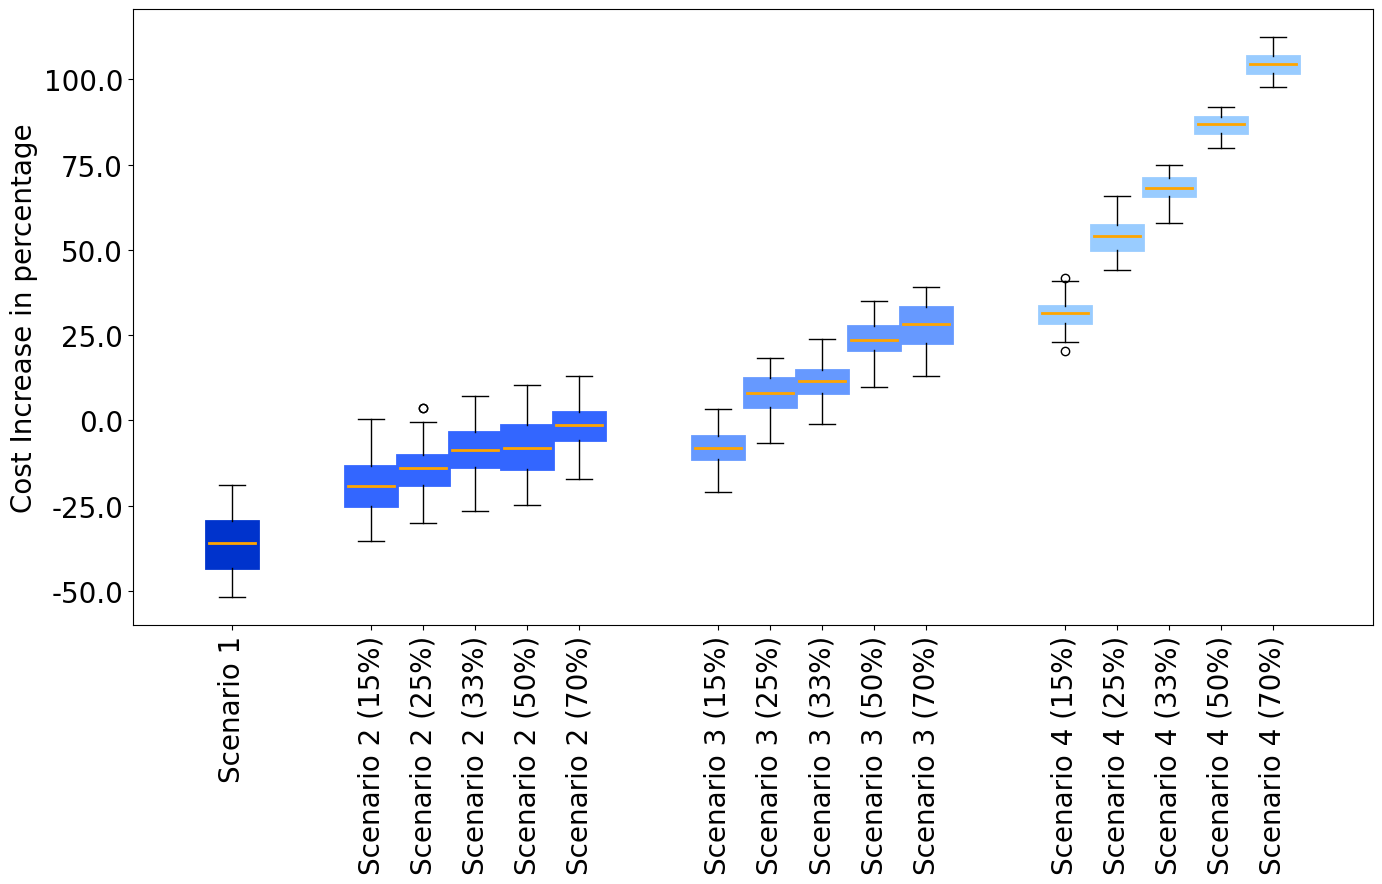

In [64]:
df = scenarios_df.iloc[1:]

# Define the number of groups and the group size
group_size = 10
num_groups = len(df) // group_size

# Create a list to store the average data for the boxplot
boxplot_data = []
group_labels = ['Scenario 1', 'Scenario 2 (15%)', 'Scenario 2 (25%)', 'Scenario 2 (33%)', 'Scenario 2 (50%)', 'Scenario 2 (70%)', 
                'Scenario 3 (15%)', 'Scenario 3 (25%)', 'Scenario 3 (33%)', 'Scenario 3 (50%)', 'Scenario 3 (70%)',
                'Scenario 4 (15%)', 'Scenario 4 (25%)', 'Scenario 4 (33%)', 'Scenario 4 (50%)', 'Scenario 4 (70%)',]
# Seed for reproducibility
np.random.seed(42)

# Loop through the DataFrame in chunks of 10, excluding groups 6 and 12
for i in range(num_groups):
    if i == 6 or i == 12:
        continue
    else:
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group_df = df.iloc[start_idx:end_idx]
        cost_increase_values = group_df['cost_increase_%'].values

        # List to store 60 averages
        averages = []

        for _ in range(60):
            # Randomly select 3 values and calculate the average
            selected_values = np.random.choice(cost_increase_values, 3, replace=False)
            averages.append(np.mean(selected_values))

        # Append the averages for the boxplot
        boxplot_data.append(averages)

# Define shades of blue
blue_shades = ['#0033cc', '#3366ff', '#6699ff', '#99ccff']  # Darker to lighter blue

# Create the boxplot
fig, ax = plt.subplots(figsize=(16, 8))

# Generate a list of colors for the boxes
colors = [blue_shades[0]] + [blue_shades[1]]* 5 + [blue_shades[2]]* 5 + [blue_shades[3]]* 5

box_width = 0.6
spacing_first_to_second = 1.0  # Space between the first and second box
spacing_every_5 = 1.0          # Additional space every 5 boxes

positions = [0]  # Start with the position for the first box
for i in range(0, 15):
    if i == 0:
        # Add spacing after the first box
        positions.append(positions[-1] + spacing_first_to_second + box_width)
    elif i % 5 == 0:
        positions.append(positions[-1] + spacing_every_5 + box_width)
    else:
        # Standard positioning
        positions.append(positions[-1] + box_width)

# Create the boxplot with custom positions
for i, (data, color) in enumerate(zip(boxplot_data, colors)):
    box = ax.boxplot(data, positions=[positions[i]], patch_artist=True, widths=box_width)
    for patch in box['boxes']:
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_linewidth(2)
    for median_line in box['medians']:
        median_line.remove()
    mean_value = np.mean(data)
    print(mean_value)
    ax.plot([positions[i] - box_width / 2 + 0.035, positions[i] + box_width / 2 - 0.035], 
            [mean_value, mean_value], color='orange', linewidth=2, linestyle='-')

# Set labels and title
ax.set_xticks(positions)  # Set x-ticks at the custom positions
ax.set_xticklabels(group_labels, rotation=90, fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=20)
plt.ylabel('Cost Increase in percentage', fontsize=20)
plt.show()

41
42
45
43
47
41
48
44
49
47
47
52
56
56
59
59


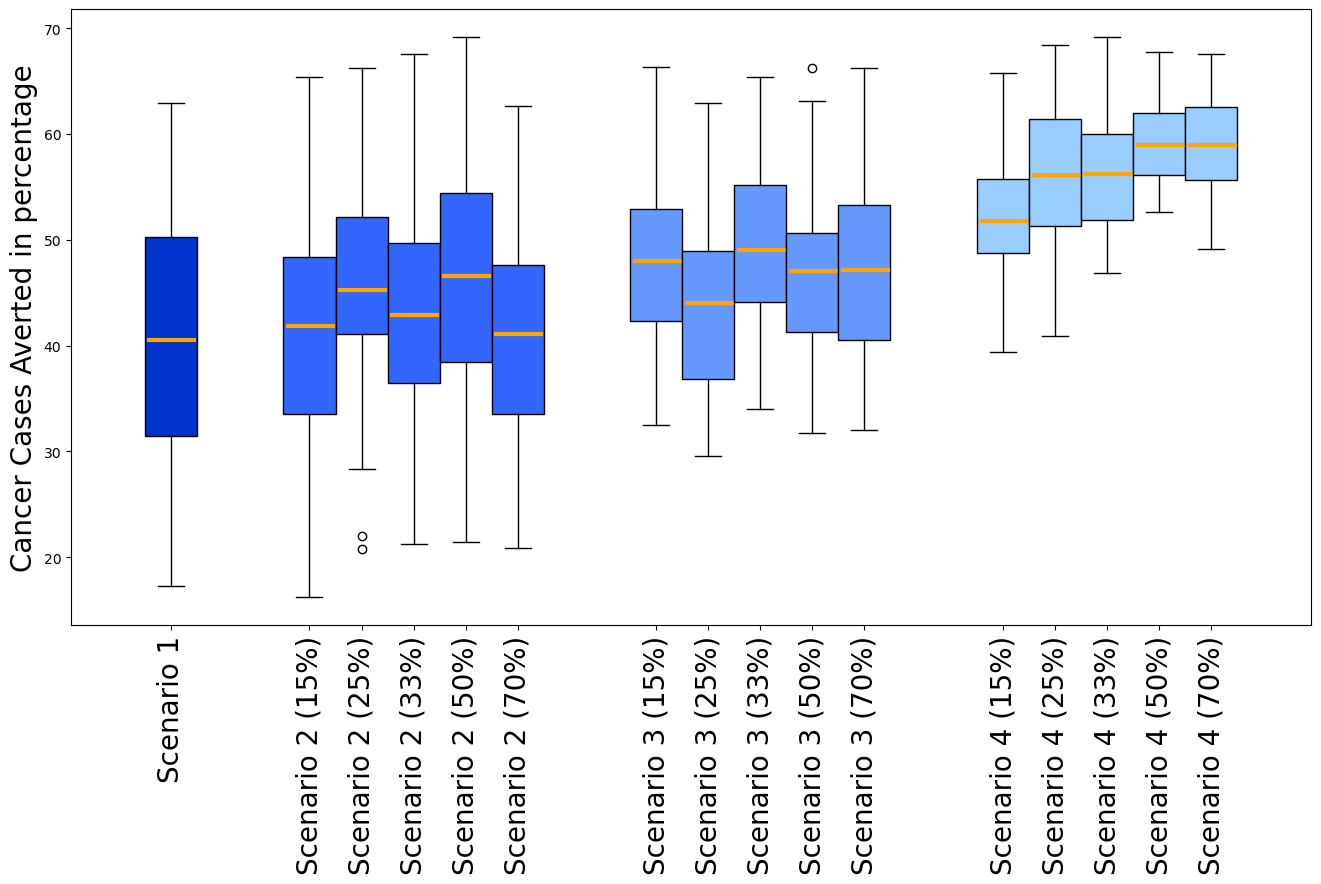

In [65]:
df = scenarios_df.iloc[1:]

# Define the number of groups and the group size
group_size = 10
num_groups = len(df) // group_size

# Create a list to store the average data for the boxplot
boxplot_data = []

# Seed for reproducibility
np.random.seed(42)

# Loop through the DataFrame in chunks of 10, excluding groups 6 and 12
for i in range(num_groups):
    if i == 6 or i == 12:
        continue
    else:
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group_df = df.iloc[start_idx:end_idx]
        cost_increase_values = group_df['reduced_cancer_cases_%'].values

        # List to store 60 averages
        averages = []

        for _ in range(60):
            # Randomly select 3 values and calculate the average
            selected_values = np.random.choice(cost_increase_values, 3, replace=False)
            averages.append(np.mean(selected_values))

        # Append the averages for the boxplot
        boxplot_data.append(averages)

# Set the figure size (width, height) in inches
blue_shades = ['#0033cc', '#3366ff', '#6699ff', '#99ccff']  # Darker to lighter blue

# Create the boxplot
fig, ax = plt.subplots(figsize=(16, 8))

# Generate a list of colors for the boxes
colors = [blue_shades[0]] + [blue_shades[1]]* 5 + [blue_shades[2]]* 5 + [blue_shades[3]]* 5

box_width = 0.6
spacing_first_to_second = 1.0  # Space between the first and second box
spacing_every_5 = 1.0          # Additional space every 5 boxes

positions = [0]  # Start with the position for the first box
for i in range(0, 15):
    if i == 0:
        # Add spacing after the first box
        positions.append(positions[-1] + spacing_first_to_second + box_width)
    elif i % 5 == 0:
        positions.append(positions[-1] + spacing_every_5 + box_width)
    else:
        # Standard positioning
        positions.append(positions[-1] + box_width)

# Create the boxplot with custom positions
for i, (data, color) in enumerate(zip(boxplot_data, colors)):
    box = ax.boxplot(data, positions=[positions[i]], patch_artist=True, widths=box_width)
    for patch in box['boxes']:
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
    for median_line in box['medians']:
        median_line.remove()
    mean_value = np.mean(data)
    ax.plot([positions[i] - box_width / 2 + 0.05, positions[i] + box_width / 2 - 0.03], 
            [mean_value, mean_value], color='orange', linewidth=3, linestyle='-')
    print(round(mean_value))

# Set labels and title
ax.set_xticks(positions)  # Set x-ticks at the custom positions
ax.set_xticklabels(group_labels, rotation=90, fontsize=20)
#ax.set_yticklabels(ax.get_yticks(), fontsize=20)
plt.ylabel('Cancer Cases Averted in percentage', fontsize=20)
plt.show()

In [66]:
def remove_outliers_iqr(data):
    # Convert data to a numpy array for convenience
    data = np.array(data)
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Determine bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    
    return filtered_data

In [67]:
gdp = [3895*(1+inflation)**i for i in range(67)][1:]

-8819.761111111113
-4391.2
-2964.483333333333
-1888.8055555555554
-1524.0666666666664
-265.55
-1506.3500000000001
1934.8555555555554
3003.516666666667
5190.744444444444
6274.416666666667
7679.794444444444
11209.294444444444
13046.644444444446
15846.061111111108
19334.155555555553


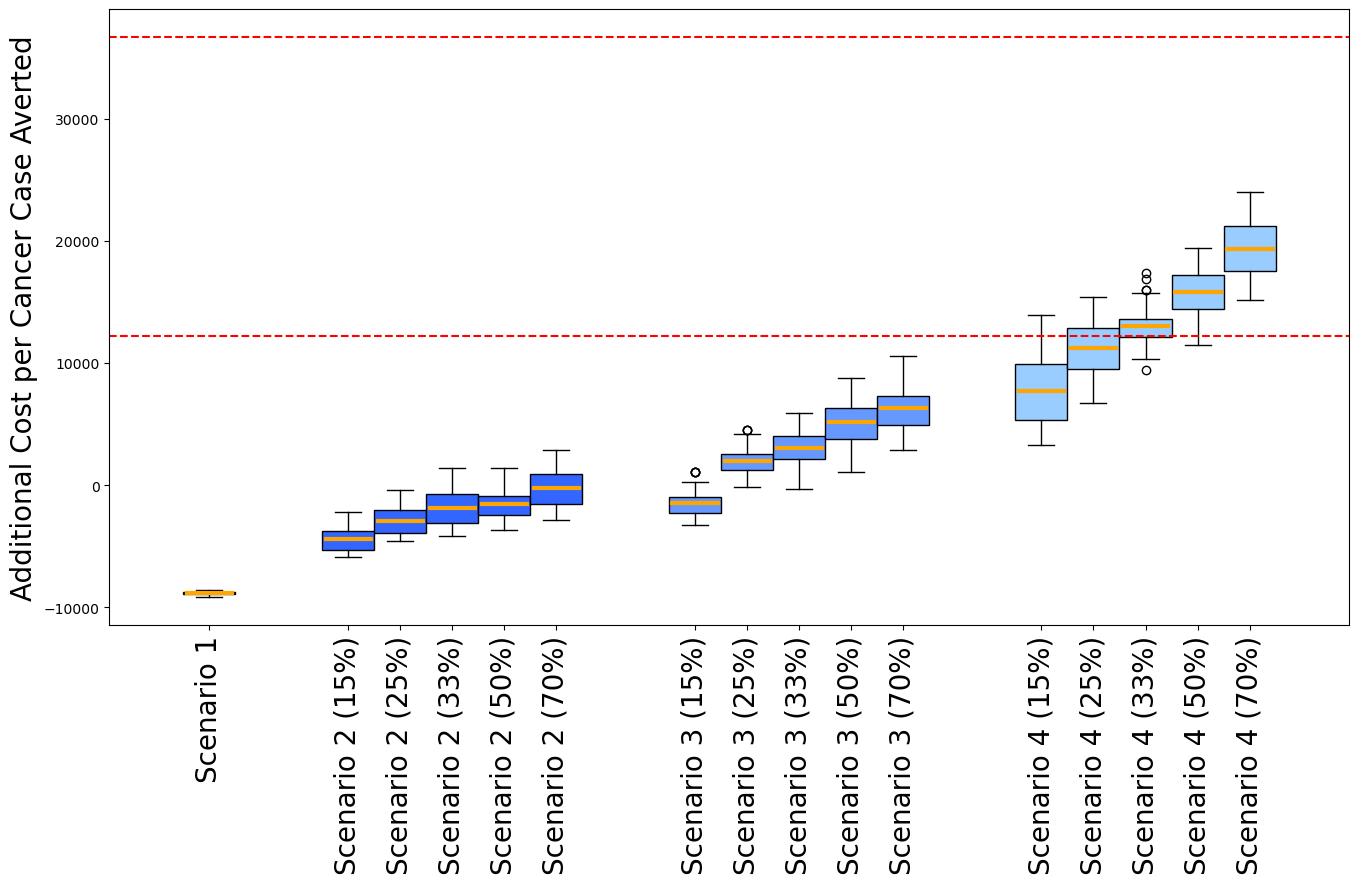

In [68]:
df = scenarios_df.iloc[1:]

# Define the number of groups and the group size
group_size = 10
num_groups = len(df) // group_size

# Create a list to store the average data for the boxplot
boxplot_data = []

# Seed for reproducibility
np.random.seed(4)

# Loop through the DataFrame in chunks of 10, excluding groups 6 and 12
for i in range(num_groups):
    if i == 6 or i == 12:
        continue
    else:
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group_df = df.iloc[start_idx:end_idx]
        cost_increase_values = group_df['metric'].values
        cost_increase_values = remove_outliers_iqr(cost_increase_values)
        # List to store 60 averages
        averages = []

        for _ in range(60):
            # Randomly select 3 values and calculate the average
            selected_values = np.random.choice(cost_increase_values, 3, replace=False)
            averages.append(np.mean(selected_values))

        # Append the averages for the boxplot
        boxplot_data.append(averages)


blue_shades = ['#0033cc', '#3366ff', '#6699ff', '#99ccff']  # Darker to lighter blue

# Create the boxplot
fig, ax = plt.subplots(figsize=(16, 8))

# Generate a list of colors for the boxes
colors = [blue_shades[0]] + [blue_shades[1]]* 5 + [blue_shades[2]]* 5 + [blue_shades[3]]* 5

box_width = 0.6
spacing_first_to_second = 1.0  # Space between the first and second box
spacing_every_5 = 1.0          # Additional space every 5 boxes

positions = [0]  # Start with the position for the first box
for i in range(0, 15):
    if i == 0:
        # Add spacing after the first box
        positions.append(positions[-1] + spacing_first_to_second + box_width)
    elif i % 5 == 0:
        positions.append(positions[-1] + spacing_every_5 + box_width)
    else:
        # Standard positioning
        positions.append(positions[-1] + box_width)

# Create the boxplot with custom positions
for i, (data, color) in enumerate(zip(boxplot_data[:], colors)):
    box = ax.boxplot(data, positions=[positions[i]], patch_artist=True, widths=box_width)
    for patch in box['boxes']:
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
    for median_line in box['medians']:
        median_line.remove()
    mean_value = np.mean(data)
    print(mean_value)
    ax.plot([positions[i] - box_width / 2 + 0.045, positions[i] + box_width / 2 - 0.035], 
            [mean_value, mean_value], color='orange', linewidth=3, linestyle='-')


# Set labels and title
ax.set_xticks(positions)  # Set x-ticks at the custom positions
ax.set_xticklabels(group_labels, rotation=90, fontsize=20)
#ax.set_yticklabels(ax.get_yticks(), fontsize=20)

ax.axhline(y=np.mean(gdp), color='r', linestyle='--', label='average GDP per capita (2025-2090)')
ax.axhline(y=3*np.mean(gdp), color='r', linestyle='--', label='3 times average GDP per capita (2025-2090)')
plt.ylabel('Additional Cost per Cancer Case Averted', fontsize=20)


plt.show()